This tutorial shows how to calculate a extreme regime for a driver descriptor fitting the upper tail of the distribution to a GPD or GEV and adding confidence bands through boostrapping.

In [49]:
# Python 2/3 setup 
from __future__ import (absolute_import, division, print_function, unicode_literals)
# from builtins import *

In [50]:
# Juypyter setup

#import matplotlib
#matplotlib.use('nbagg')

%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Import Packages

In [51]:
import numpy as np
import pandas as pd
from climate import tests, analysis, read
from climate.stats import extremal, empirical_distributions, fitting
from tqdm import tqdm
import matplotlib.pyplot as plt

In [52]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 5)
fig_x_size = 20
fig_y_size = 10

## Read SIMAR file

In [53]:
data_file = 'SIMAR_1052046'
full_data_path = os.path.join('..', '..', '..', '..', 'data', 'simar')
data_simar, code = read.simar(data_file, path=full_data_path)
data_simar

,Hm0,Tp,DirM,VelV,DirV
AA_MM_DD_HH,,,,,
1958-01-04 00:00:00,2.1,10.8,249.0,7.9,172.0
1958-01-04 01:00:00,2.1,10.6,250.0,7.5,170.0
1958-01-04 02:00:00,2.1,10.6,251.0,7.1,169.0
1958-01-04 03:00:00,2.1,10.6,252.0,6.7,167.0
1958-01-04 04:00:00,2.1,10.6,253.0,6.3,162.0
...,...,...,...,...,...
2017-08-06 20:00:00,0.6,9.7,287.0,4.2,301.0
2017-08-06 21:00:00,0.6,9.7,286.0,4.1,288.0
2017-08-06 22:00:00,0.6,9.7,286.0,3.1,269.0


# Extreme regime using Peaks over threshold

## Data inputs

In [54]:
# Inputs
data_file = 'SIMAR_1052046'
threshold_percentile = 95
data_column = 'Hm0'
threshold = np.percentile(data_simar[data_column], 95)
minimum_interarrival_time = pd.Timedelta('3 days')
minimum_cycle_length = pd.Timedelta('3 hours')
interpolation = True
interpolation_method = 'linear'
interpolation_freq = '1min'
truncate = False
extra_info = False
n_sim_boot = 100
alpha = 0.05  # Confidence level

## Storm cycles calculations

In [55]:
# Storm cycles calculation
cycles, calm_periods = extremal.extreme_events(data_simar, 'Hm0', threshold, minimum_interarrival_time,
                                               minimum_cycle_length, interpolation, interpolation_method,
                                               interpolation_freq, truncate, extra_info)

# Peaks over threshold
peaks_over_thres = extremal.events_max(cycles)

## POT Empirical distributions

In [56]:
# POT Empirical distribution
ecdf_pot = empirical_distributions.ecdf_histogram(peaks_over_thres)
n_peaks_year = len(peaks_over_thres) / len(data_simar['Hm0'].index.year.unique())
ecdf_pot_rp = extremal.return_period_curve(n_peaks_year, ecdf_pot)

## Fit POT to GPD

In [57]:
# Fit POT to Scipy-GPD
(param_orig, x_gpd, y_gpd, y_gpd_rp) = extremal.extremal_distribution_fit(data=data_simar, var_name='Hm0',
                                                                          sample=peaks_over_thres,
                                                                          threshold=threshold, fit_type='gpd',
                                                                          x_min=0.90*min(peaks_over_thres),
                                                                          x_max=1.5*max(peaks_over_thres),
                                                                          n_points=1000,
                                                                          cumulative=True)

## Confidence bands through bootstrapping

In [58]:
# Add confidence bands to asses the uncertainty (Bootstrapping)
boot_extreme = extremal.extremal_distribution_fit_bootstrapping(sample=peaks_over_thres,
                                                                n_sim_boot=n_sim_boot,
                                                                data=data_simar,
                                                                var_name='Hm0',
                                                                threshold=threshold,
                                                                param_orig=param_orig,
                                                                fit_type='gpd',
                                                                x_min=0.90 * min(peaks_over_thres),
                                                                x_max=1.5 * max(peaks_over_thres),
                                                                alpha=alpha)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.36it/s]


## Representation

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.64it/s]


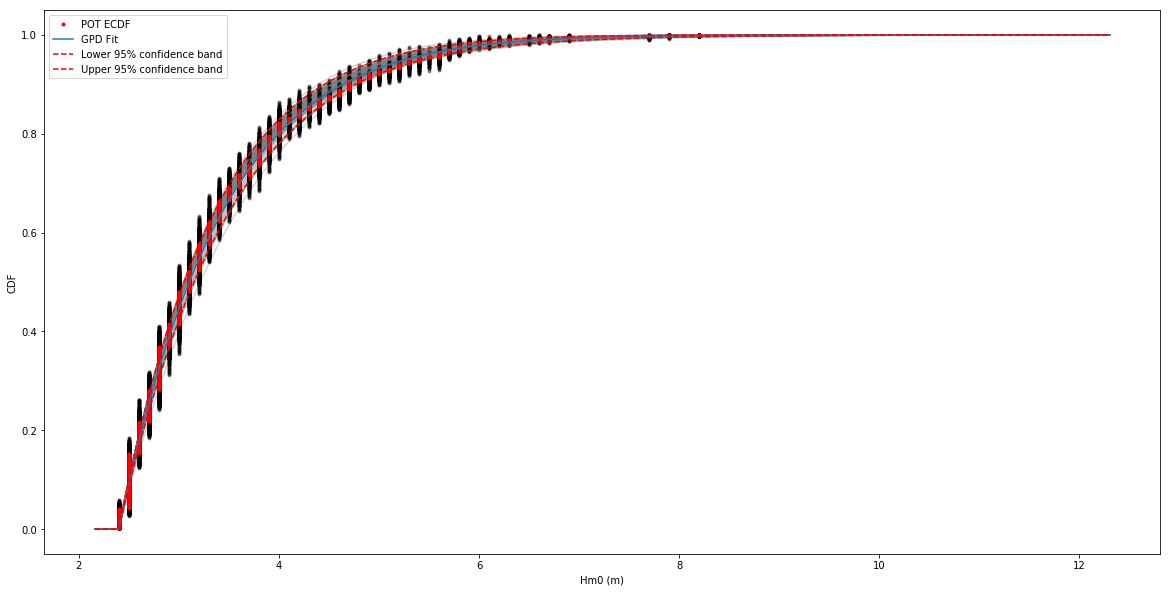

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 201.21it/s]


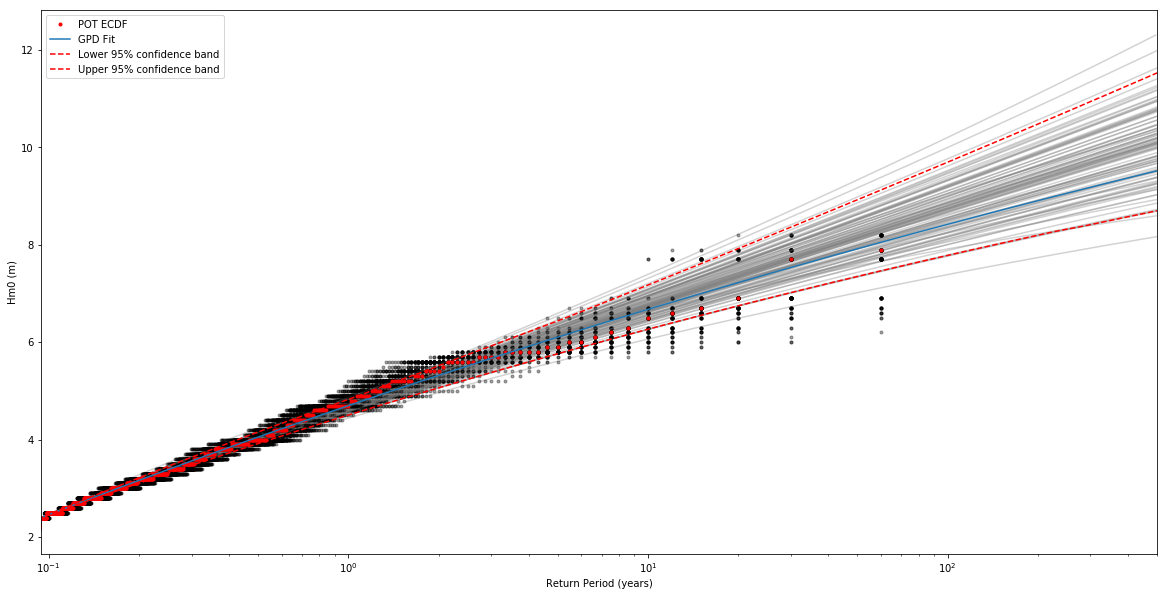

In [59]:
# Representation
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()

for sim in tqdm(range(n_sim_boot)):
    ax.plot(x_gpd, boot_extreme['y_boot'][sim], 'grey', alpha=0.35)
    ax.plot(boot_extreme['ecdf_boot'][sim].index, boot_extreme['ecdf_boot'][sim], '.k', alpha=0.35)

ax.plot(ecdf_pot.index, ecdf_pot, 'r.', label='POT ECDF')
ax.plot(x_gpd, y_gpd, label='GPD Fit')
ax.plot(x_gpd, boot_extreme['lower_band'], '--r', label='Lower 95% confidence band')
ax.plot(x_gpd, boot_extreme['upper_band'], '--r', label='Upper 95% confidence band')
plt.xlabel('Hm0 (m)')
plt.ylabel('CDF')
ax.legend()
plt.show()

# Representation
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()

for sim in tqdm(range(n_sim_boot)):
    ax.semilogx(boot_extreme['y_boot_rp'][sim], x_gpd, 'grey', alpha=0.35)
    ax.semilogx(boot_extreme['ecdf_boot_rp'][sim], boot_extreme['ecdf_boot_rp'][sim].index, '.k', alpha=0.35)

ax.semilogx(ecdf_pot_rp, ecdf_pot_rp.index, '.r', label='POT ECDF')
ax.semilogx(y_gpd_rp, x_gpd, label='GPD Fit')
ax.semilogx(boot_extreme['upper_band_rp'], x_gpd, '--r', label='Lower 95% confidence band')
ax.semilogx(boot_extreme['lower_band_rp'], x_gpd, '--r', label='Upper 95% confidence band')
plt.xlim(0, 500)
ax.legend()
plt.xlabel('Return Period (years)')
plt.ylabel('Hm0 (m)')
plt.show()

# Extreme regime using Annual Maxima

In [60]:
# Inputs
data_file = 'SIMAR_1052046'
threshold_percentile = 95
n_sim_boot = 100
alpha = 0.05  # Confidence level

In [61]:
# Calculation of the annual maxima sample
annual_maxima = extremal.annual_maxima_calculation(data_simar['Hm0'])

In [62]:
# Annual Maxima Empirical distribution
ecdf_am = empirical_distributions.ecdf_histogram(annual_maxima)
ecdf_am_rp = extremal.return_period_curve(1, ecdf_am)

In [63]:
# Fit Annual Maxima to GEV
(param_orig, x_gev, y_gev, y_gev_rp) = extremal.extremal_distribution_fit(data=data_simar, var_name='Hm0',
                                                                          sample=annual_maxima,
                                                                          threshold=threshold, fit_type='gev',
                                                                          x_min=0.90*min(annual_maxima),
                                                                          x_max=1.5*max(annual_maxima),
                                                                          n_points=1000,
                                                                          cumulative=True)

In [64]:
# Add confidence bands to asses the uncertainty (Bootstrapping)
boot_extreme = extremal.extremal_distribution_fit_bootstrapping(sample=annual_maxima,
                                                                n_sim_boot=n_sim_boot,
                                                                data=data_simar,
                                                                var_name='Hm0',
                                                                threshold=threshold,
                                                                param_orig=param_orig,
                                                                fit_type='gev',
                                                                x_min=0.90 * min(
                                                                annual_maxima),
                                                                x_max=1.5 * max(annual_maxima),
                                                                alpha=alpha)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.71it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 234.19it/s]


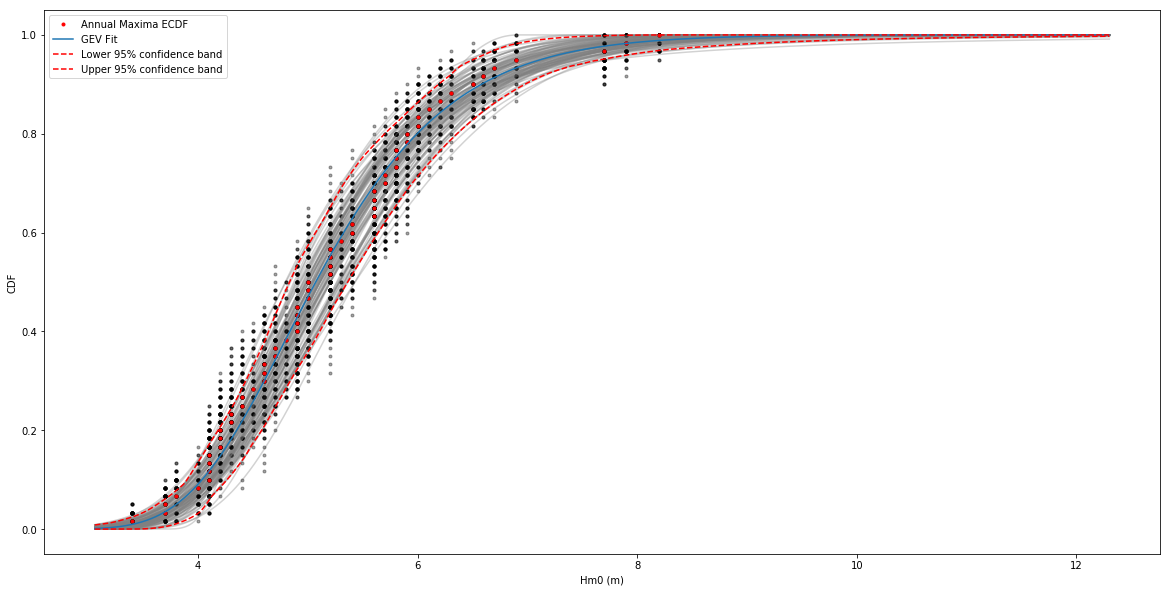

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 206.61it/s]


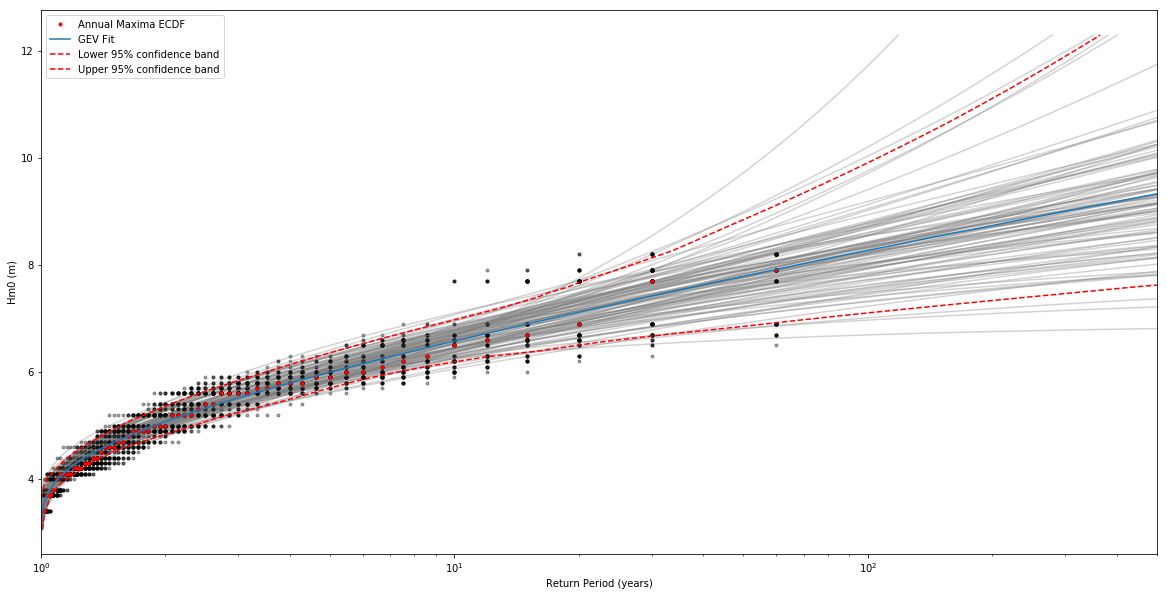

In [65]:
# Representation
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()

for sim in tqdm(range(n_sim_boot)):
    ax.plot(x_gev, boot_extreme['y_boot'][sim], 'grey', alpha=0.35)
    ax.plot(boot_extreme['ecdf_boot'][sim].index, boot_extreme['ecdf_boot'][sim], '.k', alpha=0.35)

ax.plot(ecdf_am.index, ecdf_am, 'r.', label='Annual Maxima ECDF')
ax.plot(x_gev, y_gev, label='GEV Fit')
ax.plot(x_gev, boot_extreme['lower_band'], '--r', label='Lower 95% confidence band')
ax.plot(x_gev, boot_extreme['upper_band'], '--r', label='Upper 95% confidence band')
plt.xlabel('Hm0 (m)')
plt.ylabel('CDF')
ax.legend()
plt.show()

# Representation
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()

for sim in tqdm(range(n_sim_boot)):
    ax.semilogx(boot_extreme['y_boot_rp'][sim], x_gev, 'grey', alpha=0.35)
    ax.semilogx(boot_extreme['ecdf_boot_rp'][sim], boot_extreme['ecdf_boot_rp'][sim].index, '.k', alpha=0.35)

ax.semilogx(ecdf_am_rp, ecdf_am_rp.index, '.r', label='Annual Maxima ECDF')
ax.semilogx(y_gev_rp, x_gev, label='GEV Fit')
ax.semilogx(boot_extreme['upper_band_rp'], x_gev, '--r', label='Lower 95% confidence band')
ax.semilogx(boot_extreme['lower_band_rp'], x_gev, '--r', label='Upper 95% confidence band')
plt.xlim(0, 500)
ax.legend()
plt.xlabel('Return Period (years)')
plt.ylabel('Hm0 (m)')
plt.show()